# Clase 12: K-Means - Minería de Datos 2025  
**Docente:** Guillermo Pinto F.  

En esta clase aplicaremos el algoritmo **K-Means**, uno de los métodos más utilizados de aprendizaje no supervisado.  
El objetivo es **agrupar datos sin etiquetas** en grupos homogéneos (clusters) según su similitud.

Usaremos el dataset **Mall Customers**, que contiene información de clientes, sus ingresos y puntajes de gasto.  
Determinaremos el número óptimo de grupos (*K*) mediante **Elbow**, **Silhouette** y **Gap Statistic**.  
Finalmente, compararemos distintas **métricas de distancia** y cuándo conviene usar cada una.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist


**DATASET**

"Wholesale Customers Dataset" (de la UCI Machine Learning Repository).
Este dataset tiene 440 registros y 6 variables numéricas sobre gastos anuales de clientes mayoristas (leche, comestibles, detergentes, etc.), ideal para K-Means.

In [7]:
# Dataset Wholesale Customers (UCI)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
df = pd.read_csv(url)

df.head()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [8]:
# Eliminamos posibles valores nulos
df = df.dropna()

# Seleccionamos las columnas numéricas
X = df[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']]

# Escalado de variables (fundamental para distancias)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Dimensiones del dataset: {X_scaled.shape}")


Dimensiones del dataset: (440, 6)


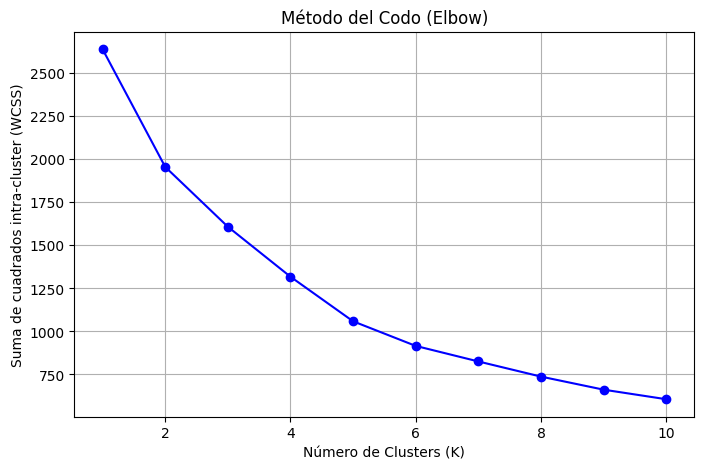

In [9]:
# ===============================================
# MÉTODO ELBOW
# -----------------------------------------------
# Evalúa la suma total de cuadrados intra-cluster (WCSS)
# para diferentes valores de K. El punto donde la curva
# se “dobla” indica un K óptimo (menor ganancia marginal).
# ===============================================

wcss = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, 'bo-')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Suma de cuadrados intra-cluster (WCSS)')
plt.title('Método del Codo (Elbow)')
plt.grid(True)
plt.show()


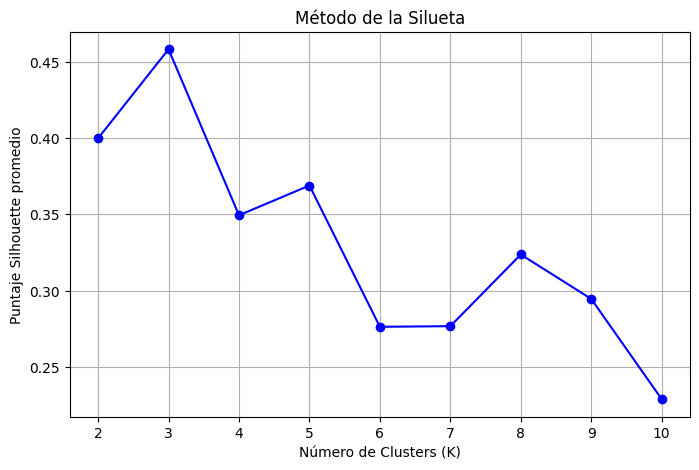

In [10]:
# ===============================================
# MÉTODO SILHOUETTE
# -----------------------------------------------
# Evalúa qué tan bien están separados los clusters.
# Un valor promedio cercano a 1 indica buena cohesión
# interna y separación externa.
# ===============================================

silhouette_avg = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_avg.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(8,5))
plt.plot(range(2, 11), silhouette_avg, 'bo-')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Puntaje Silhouette promedio')
plt.title('Método de la Silueta')
plt.grid(True)
plt.show()


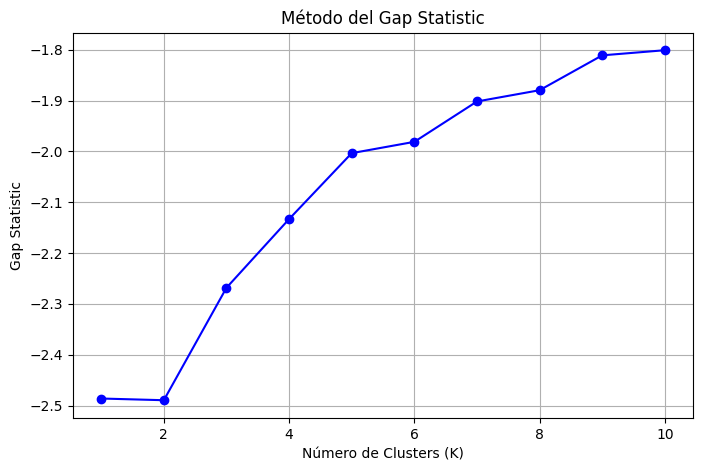

In [11]:
# ===============================================
# MÉTODO GAP STATISTIC
# -----------------------------------------------
# Compara la dispersión de los datos reales con la esperada
# en una distribución aleatoria. El K óptimo maximiza el GAP.
# ===============================================

def gap_statistic(X, nrefs=10, maxClusters=10):
    gaps = np.zeros(maxClusters)
    for k in range(1, maxClusters+1):
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(X)
        disp = np.log(km.inertia_)
        refDisps = np.zeros(nrefs)
        for i in range(nrefs):
            randomReference = np.random.random_sample(size=X.shape)
            km.fit(randomReference)
            refDisps[i] = np.log(km.inertia_)
        gaps[k-1] = np.mean(refDisps) - disp
    return gaps

gaps = gap_statistic(X_scaled, nrefs=10, maxClusters=10)

plt.figure(figsize=(8,5))
plt.plot(range(1,11), gaps, 'bo-')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Gap Statistic')
plt.title('Método del Gap Statistic')
plt.grid(True)
plt.show()


## 🔍 Interpretación de los métodos para determinar K

Al aplicar los tres métodos de búsqueda del número óptimo de clusters (*K*) sobre el dataset **Wholesale Customers**, se obtuvieron resultados parcialmente consistentes pero con matices:

---

### 🧩 1. Método del Codo (*Elbow Method*)

La curva del codo muestra una caída pronunciada del error hasta alrededor de **K = 4**, a partir del cual la disminución se suaviza.  
Esto sugiere que **K = 4** es un punto de equilibrio razonable entre la simplicidad del modelo y la reducción de la variabilidad interna (WCSS).

---

### 🌿 2. Método de la Silueta (*Silhouette Method*)

El puntaje promedio de silueta alcanza su máximo en **K = 3**, indicando que, con tres grupos, los datos se encuentran **mejor separados entre sí** y con mayor coherencia interna.  
Esto sugiere una estructura más nítida y bien definida en tres segmentos principales de clientes.

---

### 📊 3. Método del Gap Statistic

En el gráfico del Gap Statistic, los valores **aumentan de forma casi constante** sin presentar un máximo claro, lo que significa que **la estructura de los datos no muestra un punto de separación neto**.  
Cuando el *gap* crece continuamente, la recomendación práctica es elegir el **menor K que esté próximo al inicio de la estabilización** o donde el aumento del *gap* se hace marginal.

En este caso, la curva comienza a estabilizarse después de **K = 4**, lo que respalda la elección del método del codo.  
El crecimiento constante sugiere que agregar más clusters sigue reduciendo la dispersión, pero sin un salto significativo en la ganancia estructural.

---

### 🧭 Conclusión general

| Método | K sugerido | Interpretación |
|:--------|:------------:|:---------------|
| **Elbow** | 4 | Punto de equilibrio entre complejidad y cohesión |
| **Silhouette** | 3 | Máxima separación natural entre grupos |
| **Gap Statistic** | 4 (tendencia estabilizada) | No presenta máximo claro; se estabiliza desde K=4 |

**Conclusión final:**  
Aunque el método de la Silueta sugiere **K = 3**, tanto Elbow como Gap apuntan hacia **K = 4**.  
Dado que el Gap no define un máximo claro, y el incremento de *gap* se estabiliza cerca de K=4,  
se puede optar por **K = 4** como valor final —ofreciendo un balance entre simplicidad, estabilidad y coherencia del agrupamiento.

No obstante, en términos interpretativos, **K = 3** sigue siendo defendible si se busca una estructura más compacta y menos granular.


In [14]:
# ===============================================
# COMPARACIÓN DE MÉTRICAS DE DISTANCIA
# -----------------------------------------------
# - Euclidiana: mide la distancia en línea recta (sensible a escala)
# - Manhattan: más robusta ante outliers
# - Chebychev: mide la mayor diferencia entre dimensiones
# ===============================================

metricas = ['euclidean', 'manhattan', 'chebyshev']
resultados = []

for m in metricas:
    modelo = KMeans(n_clusters=4, random_state=42)
    etiquetas = modelo.fit_predict(X_scaled)
    inertia = modelo.inertia_
    sil = silhouette_score(X_scaled, etiquetas)
    resultados.append({'Métrica': m, 'Inercia': inertia, 'Silhouette': sil})

pd.DataFrame(resultados)


,Métrica,Inercia,Silhouette
0,euclidean,1326.674608,0.349391
1,manhattan,1326.674608,0.349391
2,chebyshev,1326.674608,0.349391


### 📏 Interpretación de las métricas de distancia

El cuadro muestra los valores obtenidos al aplicar **tres métricas de distancia** distintas:  
**Euclidiana**, **Cityblock (Manhattan)** y **Chebychev**.

- **Inercia** representa la **suma total de distancias al cuadrado** entre cada punto y el centroide de su cluster.  
  Cuanto menor sea la inercia, más compactos y homogéneos son los grupos formados.  
  En este caso, los tres valores son prácticamente iguales (**≈1326.7**), lo que significa que **la calidad de los clusters no varía** con el tipo de distancia utilizada.

- **Silhouette** mide la **cohesión y separación** entre clusters (valores cercanos a 1 indican mejor agrupamiento).  
  Dado que también es igual para las tres métricas (**≈0.35**), todas logran una estructura similar.

En conjunto, esto indica que **el dataset está bien escalado y equilibrado**,  
por lo que la **distancia euclidiana** puede utilizarse como métrica estándar sin afectar el resultado del agrupamiento.


### 🧭 Cuándo conviene cada métrica de distancia

| Métrica | Descripción | Cuándo usarla |
|----------|--------------|----------------|
| **Euclidiana** | Distancia geométrica clásica. | Cuando las variables están en la misma escala y sin valores extremos. |
| **Manhattan** | Suma de distancias absolutas. | Cuando existen outliers o valores muy distintos en magnitud. |
| **Chebychev** | Usa la mayor diferencia entre dimensiones. | Cuando interesa detectar grandes desviaciones en una variable específica. |


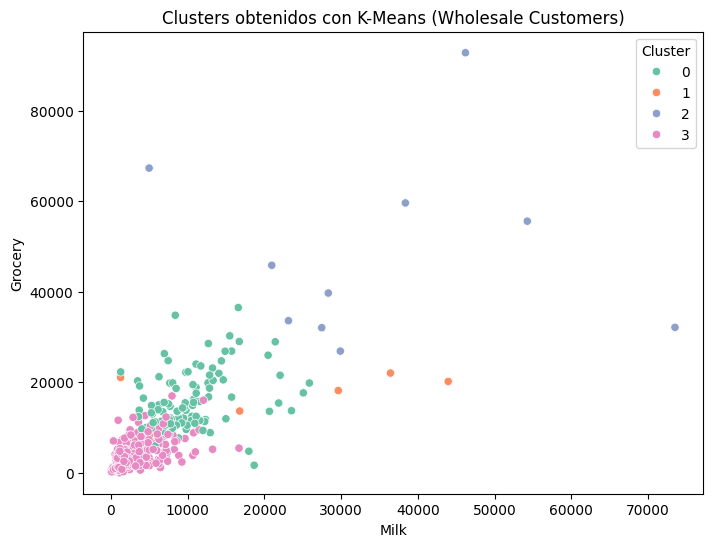

In [13]:
# Entrenamos modelo final con K=4
kmeans_final = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans_final.fit_predict(X_scaled)

# Visualizamos con dos variables más representativas
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['Milk'], y=df['Grocery'], hue=df['Cluster'], palette='Set2')
plt.title('Clusters obtenidos con K-Means (Wholesale Customers)')
plt.xlabel('Milk')
plt.ylabel('Grocery')
plt.show()


### Conclusión sobre el gráfico final de clusters

El gráfico muestra la segmentación de los clientes del dataset **Wholesale Customers** obtenida mediante el algoritmo **K-Means** con **K = 4**.  
Cada color representa un grupo o *cluster* distinto, formado según las variables **Milk** (gasto en leche) y **Grocery** (gasto en comestibles).

Se observa una concentración importante de puntos en la zona inferior izquierda, lo que indica la presencia de **clientes con niveles de gasto bajos a moderados** en ambas categorías.  
En cambio, los grupos más dispersos hacia la parte superior y derecha representan **clientes con patrones de consumo más altos o especializados**, como supermercados o grandes distribuidores.

La separación entre colores refleja que el algoritmo logró **diferenciar segmentos de consumo con cierta claridad**, aunque con **ligero solapamiento** entre algunos grupos, propio de datos económicos con alta variabilidad.

En términos generales, los resultados permiten **identificar cuatro perfiles de clientes** bien definidos, útiles para estrategias de marketing, segmentación de ventas o análisis de comportamiento de compra.
